In [80]:
# if you need to initialize the OpenAPI Key
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

In [81]:
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.document_loaders import PyPDFDirectoryLoader


In [90]:
# load the PDFs in the data folder [recipes]
from langchain.document_loaders import PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader("./data/")

In [92]:
documents = loader.load()

In [97]:
print(documents[1])

page_content='2 tablespoons finely grated fresh\npineapple, including accumulated\njuices\n1½ pounds boneless, skinless\nchicken breasts, cut into 1½-inch\nchunks\nCooked white rice, for servingStep 4\nServe the chicken over rice and top with the reserved pineapple\nsalsa.\nPrivate Notes\nLeave a Private Note on this recipe and see it here.' metadata={'source': 'data/Pineapple-Marinated Chicken Breasts Recipe - NYT Cooking.pdf', 'page': 1}


In [98]:

documents = loader.load()



embeddings = OpenAIEmbeddings()



db = FAISS.from_documents(documents, embeddings)
db.save_local("faiss_index")

In [100]:
# if you need to load db
embeddings = OpenAIEmbeddings()
db = FAISS.load_local("faiss_index", embeddings)

In [133]:
retriever = db.as_retriever(search_type="similarity_score_threshold", search_kwargs={"k": 1, "score_threshold": .7})

In [135]:
docs = retriever.get_relevant_documents('Beef Recipes')
if docs is None:
    print('No documents found')
else:
    #print type info of document
    print(docs[0])

page_content='Chili\nBy Ali Slagle\nLinda Xiao for The New York Times. Food Stylist; Hadas Smirnoff. Prop\nStylist: Megan Hedgepeth.Time1½ hours\nRating (473)\nI N G R E D I E N T S\nYield:6 to 8 servings\n2 tablespoons neutral oil, such as\ngrapeseed\n2 pounds ground beef, preferably\n20 percent fat\nSalt and pepper\n1 large yellow onion, coarsely\nchopped\n4 garlic cloves, finely chopped or\ngrated\n1 tablespoon ground cumin\n1 tablespoon store-bought or\nhomemade chili powder, plus more\nif needed\n1 chipotle pepper in adobo plus 1\nteaspoon sauce (or 1 additional\ntablespoon chili powder)\n1 (15-ounce) can tomato sauceP R E P A R A T I O N\nStep 1\nHeat the oil in a large pot or Dutch oven over medium-high.\nWorking in batches if necessary to avoid crowding the pot, use\nyour hands to break the beef into small chunks (about 2 inches\neach) and add a single layer to the pot. Season with salt and\npepper, then cook, flipping once, until browned on two sides, 4 to 6\nminutes. (Meat wo

In [136]:
from langchain.llms import OpenAI
llm = OpenAI()

In [137]:
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

In [35]:
llm = OpenAI(temperature=.7)
template = """You are a recipe search bot. Given a prompt from the end user you will generate search terms relevant to the question to help responding to the prompt.
Make sure that if the user says they don't want something that you will not generate a search term for that item, as the keyword semantic search may still return results for that item.

prompt from user: {user_prompt}
Recipe Search Terms: """

prompt_template = PromptTemplate(input_variables=["user_prompt"], template=template)
recipe_terms_chain = LLMChain(llm=llm, prompt=prompt_template)

In [13]:
templateRecipeReader = """You are a recipe recommender bot. You will be given context about a recipe. You will be knowledgable about the recipe and explain it highlighting key details like ingredients, time duration, difficulty and an over synopsis.

recipe data: {recipe_data}

Recipe Explanation Format should look like
Title: [Recipe Title], By [Author Name]
Duration: [Recipe Duration]
Ingredients: [Recipe Ingredients] 
Synopsis: [Recipe Synopsis]

Recipe Explanation based on recipe data:
"""
prompt_template_recipe_reader = PromptTemplate(input_variables=["recipe_data"], template=templateRecipeReader)
recipe_reader_chain = LLMChain(llm=llm, prompt=prompt_template_recipe_reader)

In [36]:
template_recipe_reader_v2 = """ You will be given the data of a single recipe. You will read the recipe and use only the information there to answer the user.
You will also be given a user prompt to answer. You will answer the user prompt based on the recipe data.

recipe data: {recipe_data}
user prompt: {user_prompt}

Recipe Response to user:
"""
prompt_template_recipe_reader_v2 = PromptTemplate(input_variables=["recipe_data", "user_prompt"], template=template_recipe_reader_v2)
recipe_reader_chain_v2 = LLMChain(llm=llm, prompt=prompt_template_recipe_reader_v2)

In [28]:
from IPython.display import Image
from pdf2image import convert_from_path
from IPython.display import display, Image


In [39]:
def searchRecipes(prompt, chat_history):
    # generate search terms
    search_terms_raw = recipe_terms_chain.run(user_prompt=prompt)
    # clean the search terms generated by the LLM
    search_terms = search_terms_raw.split(", ")
    # query vector db using search term

    print(f'I am searching using this search term: {search_terms[0]}')

    docs = retriever.get_relevant_documents(search_terms[0])

    print(docs[0].metadata)

    source_pdf_path = docs[0].metadata.get('source')

    doc = docs[0]

    bot_response = recipe_reader_chain_v2.run(recipe_data=doc.page_content, user_prompt=prompt)

    print(bot_response)
    pdf = open(source_pdf_path, 'rb')
    images = convert_from_path(source_pdf_path)

    for img in images:
        display(img)
        # Display the PDF file
        Image(pdf)

    chat_history.append(f"\n User Prompt:{prompt} \n Bot Response:{bot_response} \n Source Recipe: {source_pdf_path} \n Recipe Content: {doc.page_content}")
    
    return chat_history
    


I am searching using this search term: 
"no garlic no chicken recipes" OR "recipes without garlic or chicken" OR "recipes without garlic and chicken"
{'source': 'data/Garlic Chicken With Giardiniera Sauce Recipe - NYT Cooking.pdf', 'page': 0}
If you don't want garlic and chicken, you can still make this recipe without them. Simply omit the garlic and chicken from the ingredients list and substitute the olive oil, giardiniera and giardiniera brine for desired ingredients. You can use any combination of herbs, vegetables, vinegar and oil to make a delicious sauce. Enjoy!


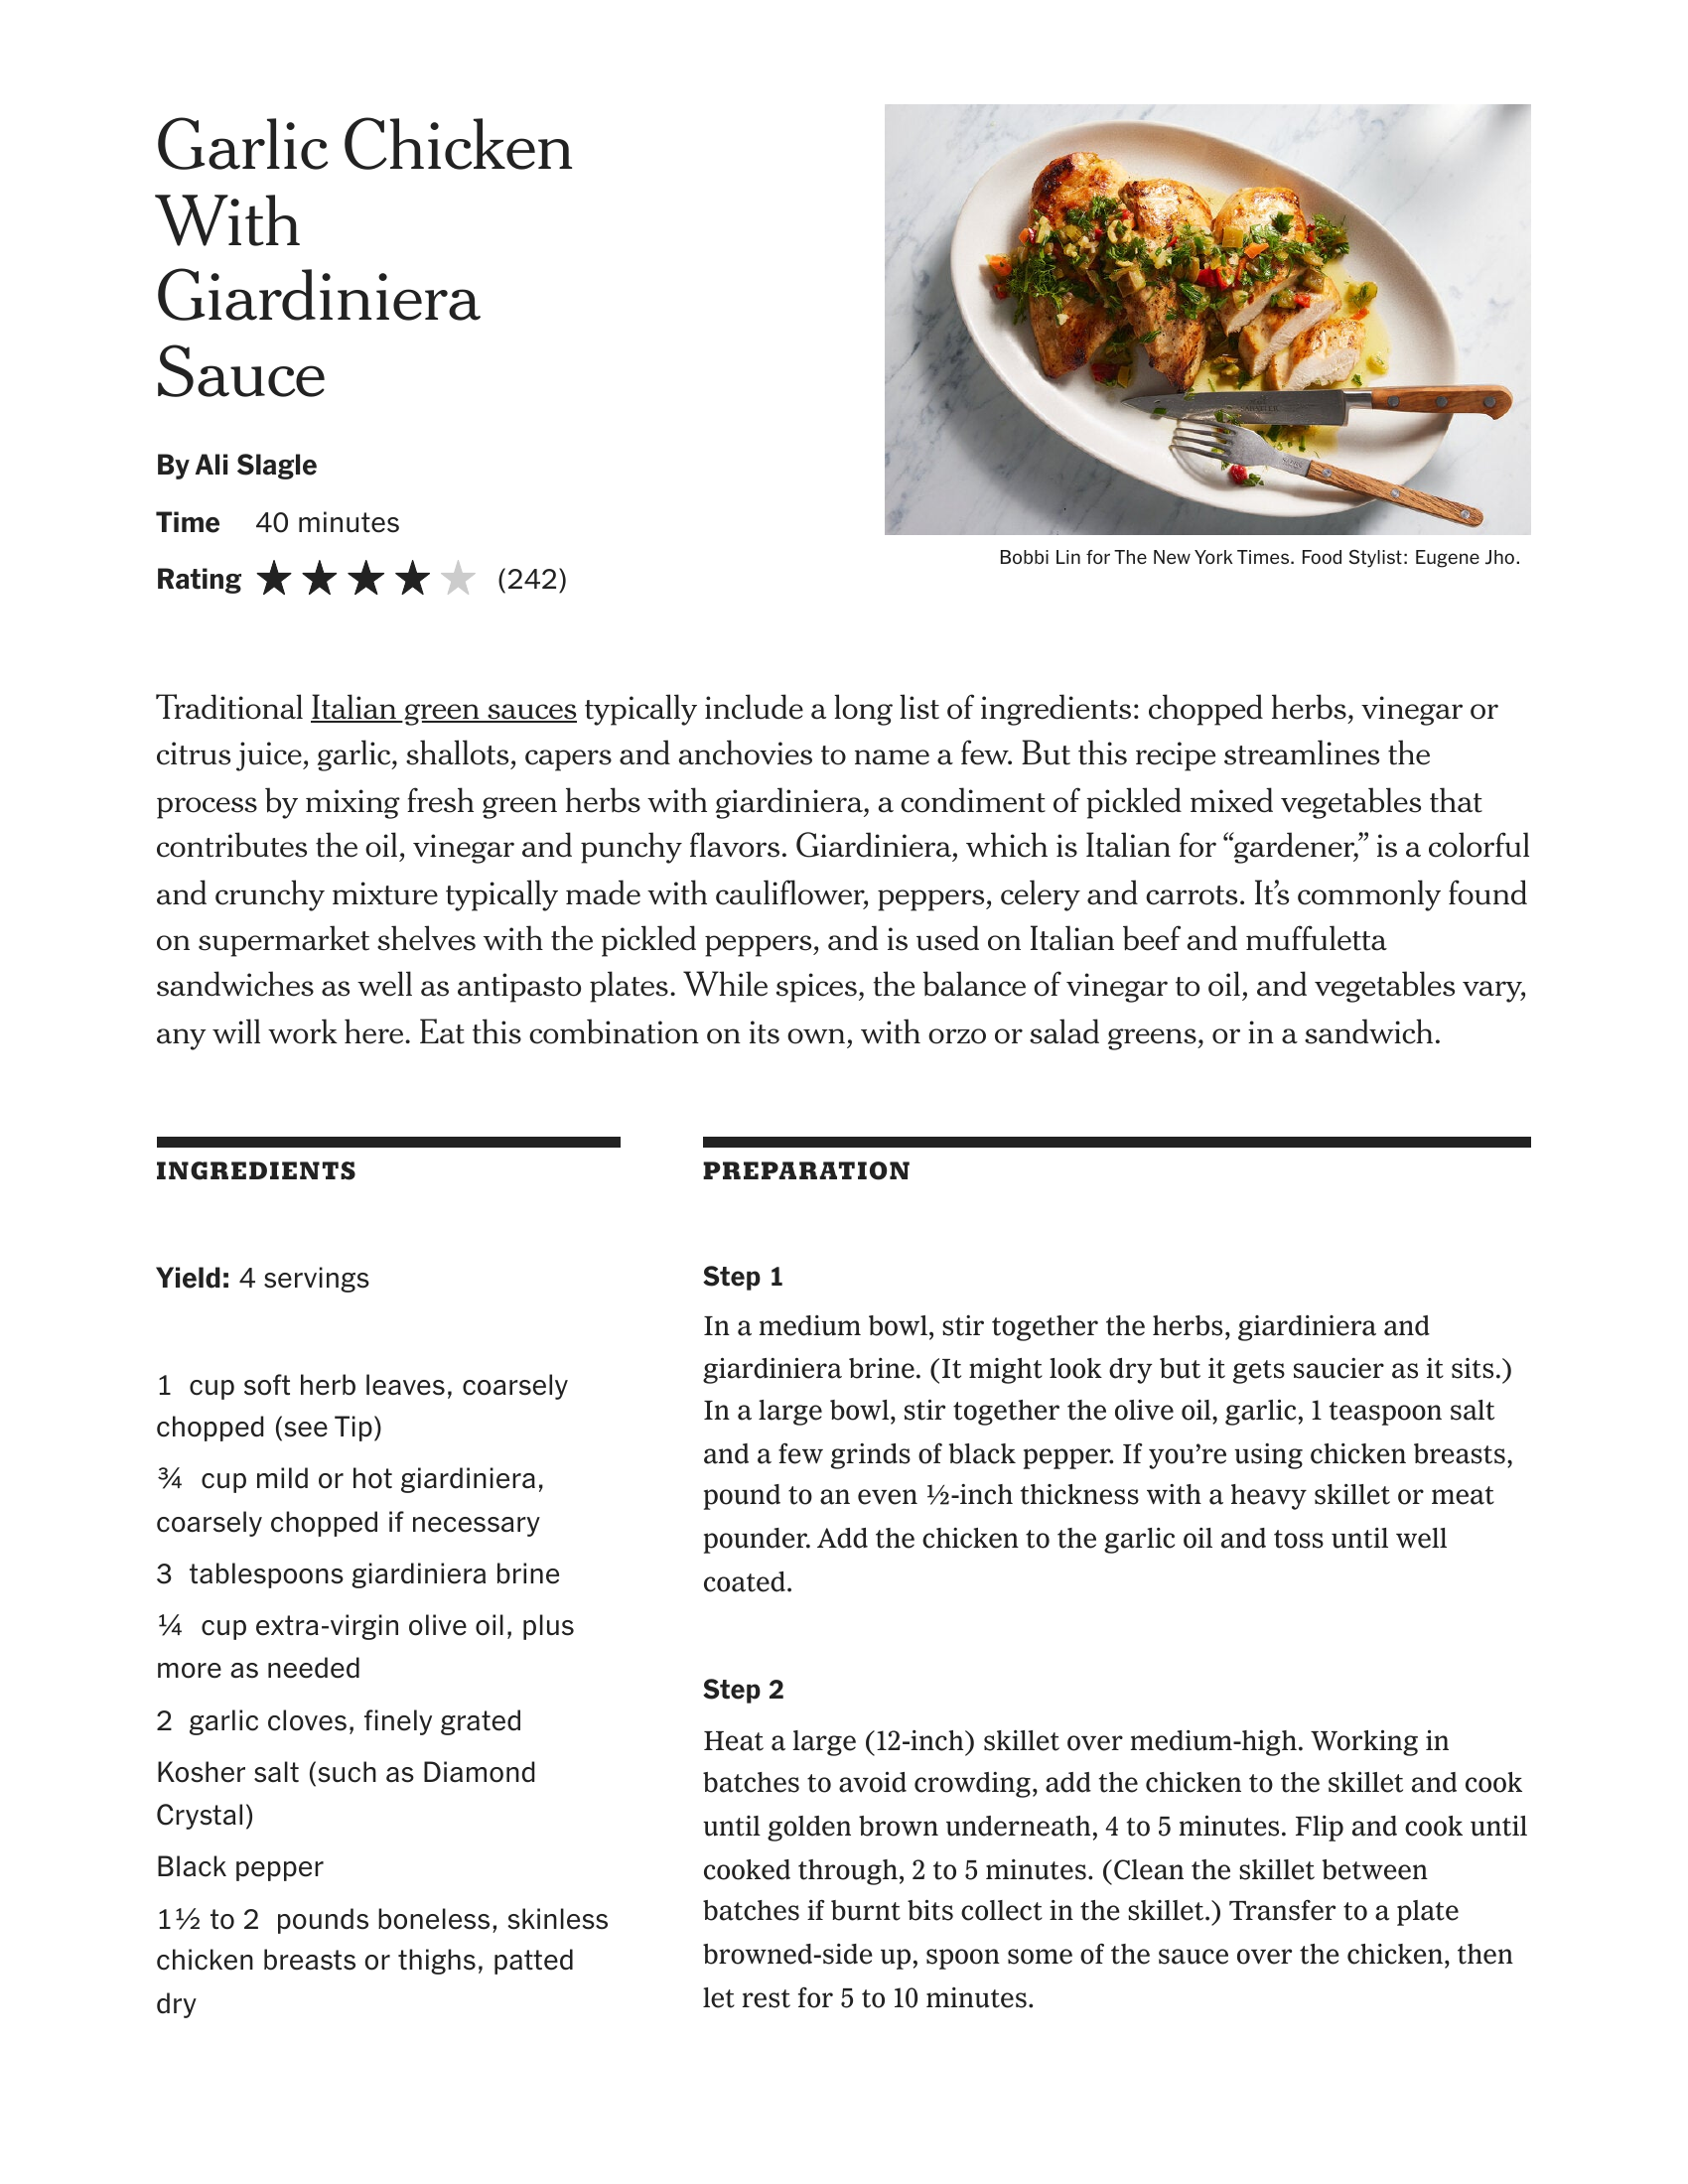

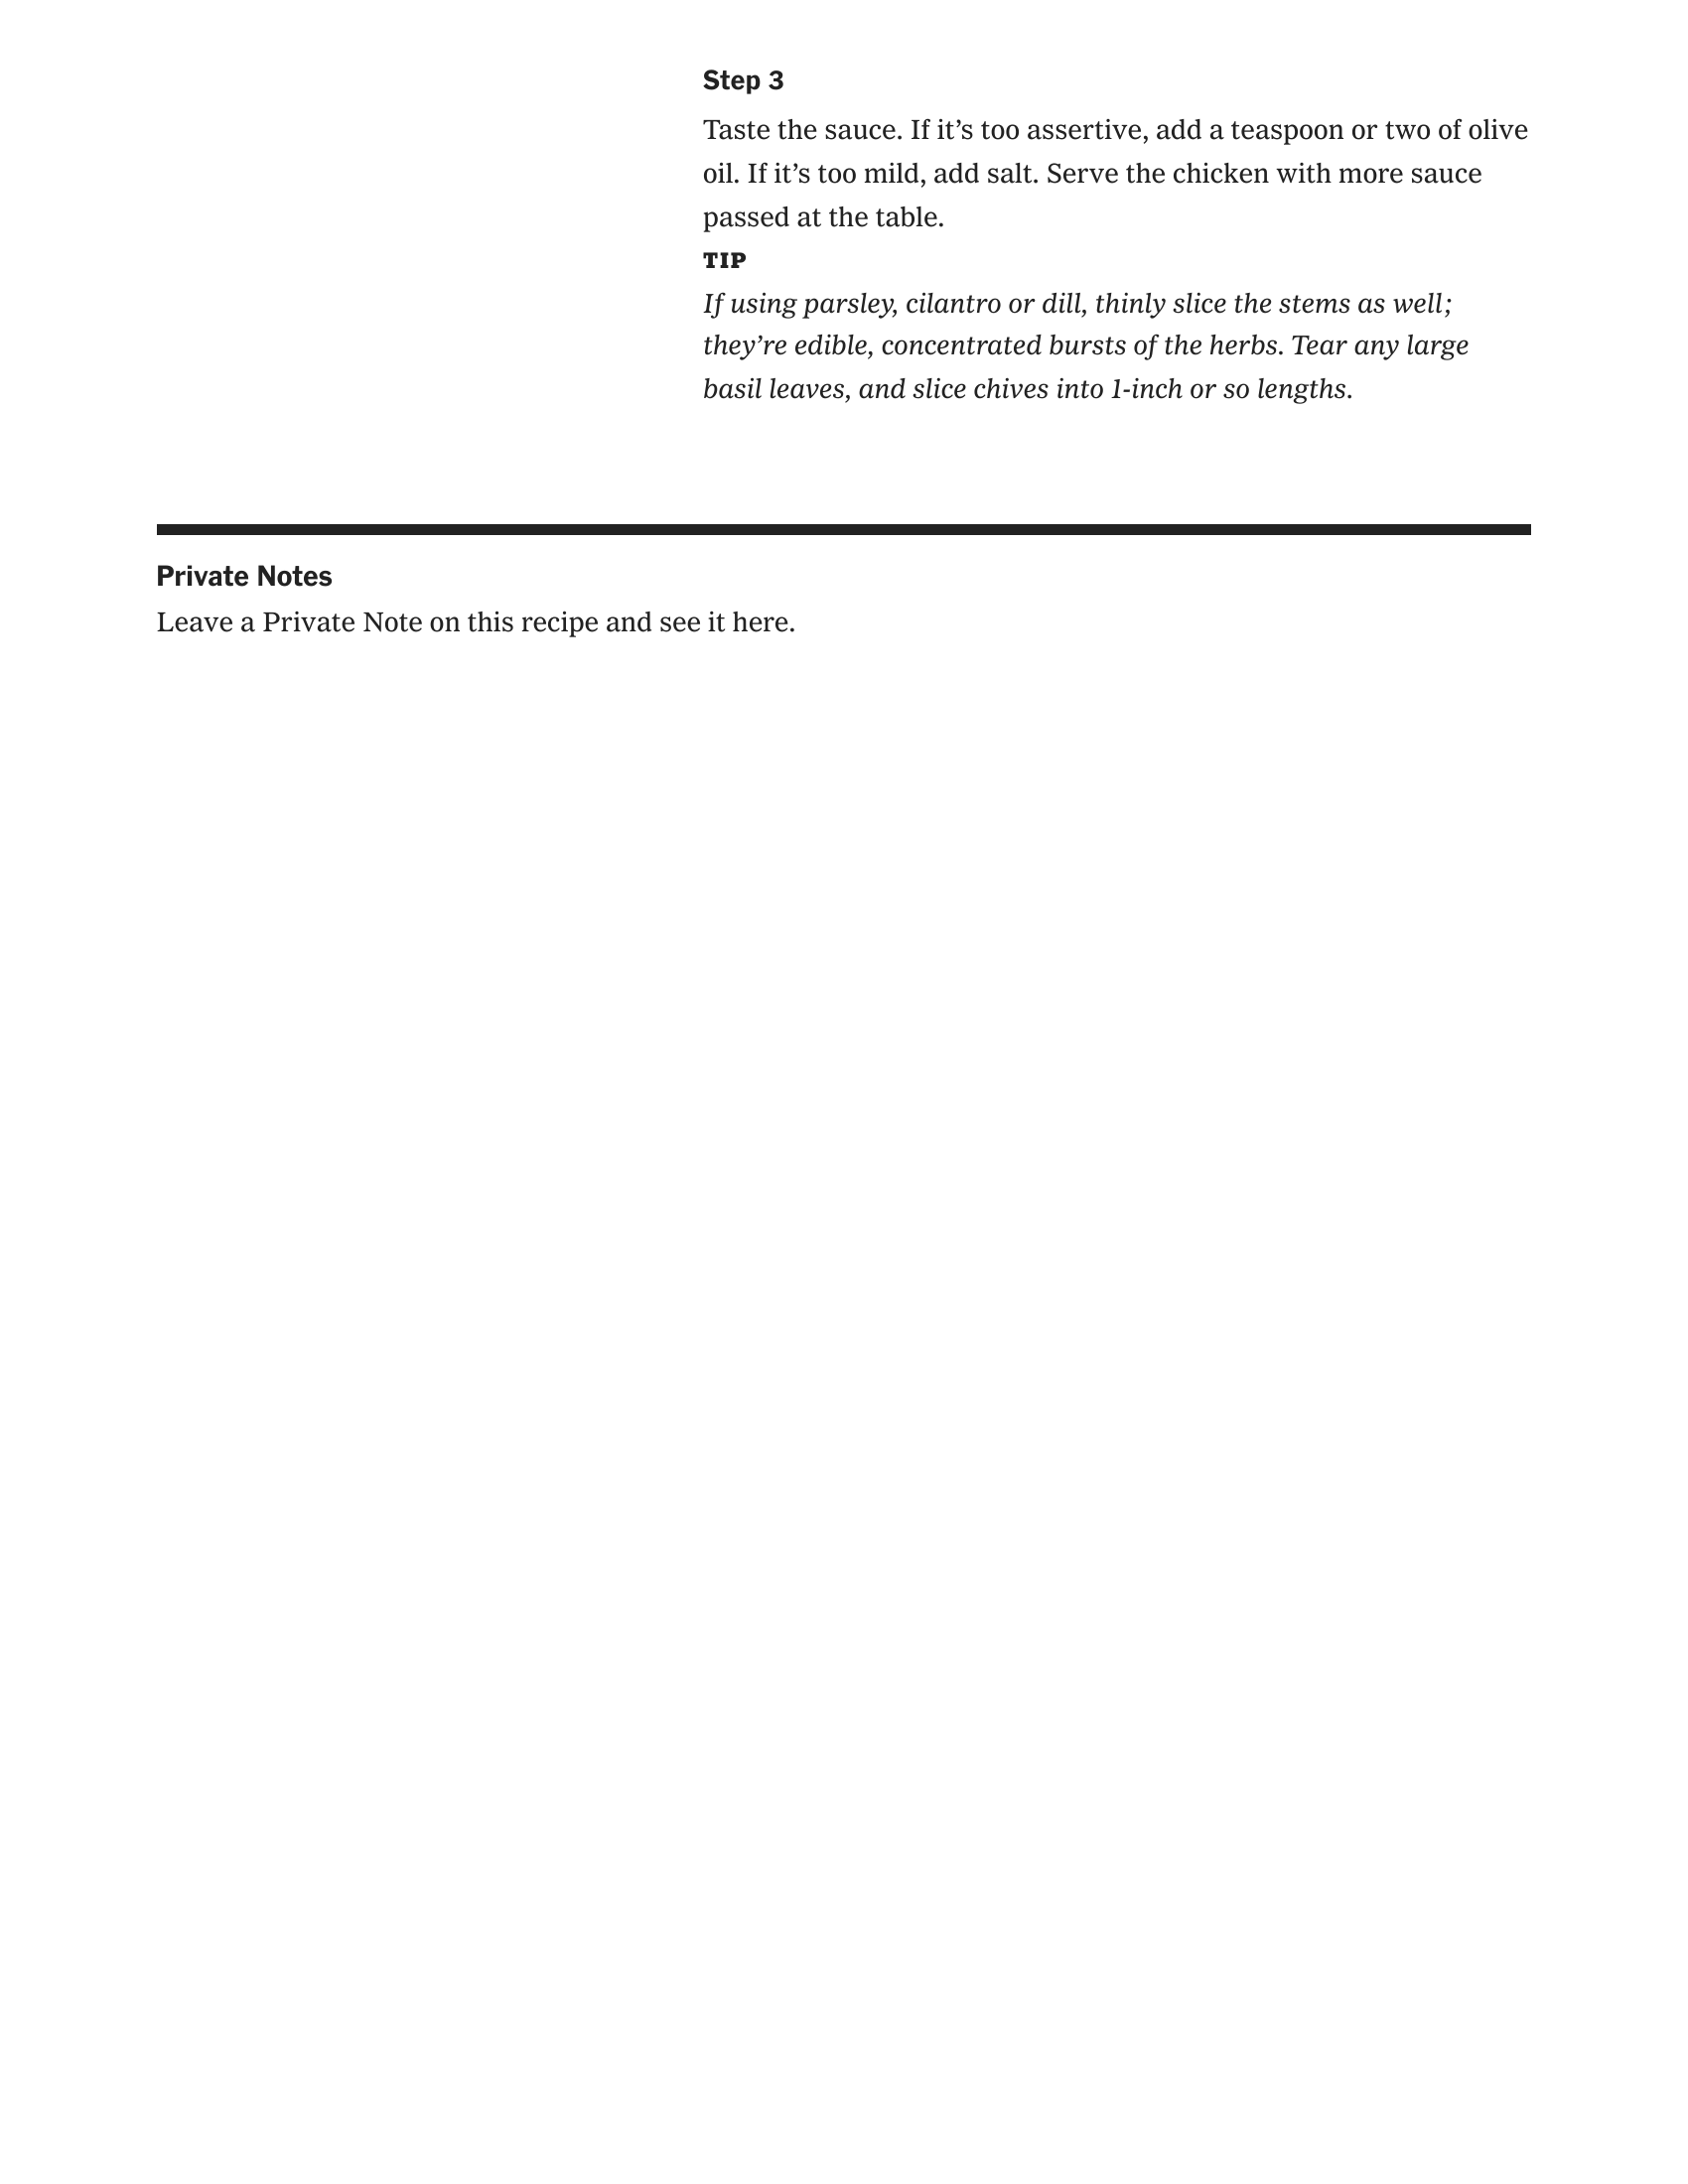

In [38]:
searchRecipes('I dont want garlic and I dont want chicken')

In [138]:

template_with_chat_history = """You are a recipe search bot. Given a prompt from the end user you will generate search terms relevant to the question to help responding to the prompt.
Make sure that if the user says they don't want something that you will not include anything related to that in your terms.

For example, if the user says they don't want to use eggs, you should not include eggs in your search terms.

prompt from user: {user_prompt}
Recipe Search Terms: """

template_with_chat_history_template = PromptTemplate(input_variables=["user_prompt"], template=template_with_chat_history)
recipe_terms_chain = LLMChain(llm=llm, prompt=template_with_chat_history_template)

In [139]:
template_recipe_reader_chat_history = """ You will be given the data of a recipe. You will read the recipe and use only the information there to answer the user.
You will also be given a user prompt to answer. You will answer the user prompt based on the recipe data.

previous chat history: {chat_history}

most relevant recipe data: {recipe_data}
use the most relevant recipe data and the user prompt to answer the user.

user prompt: {user_prompt}

Recipe Response to user:
"""
prompt_template_recipe_reader_chat_history = PromptTemplate(input_variables=["recipe_data", "user_prompt", "chat_history"], template=template_recipe_reader_chat_history)
recipe_reader_chain_chat_history = LLMChain(llm=llm, prompt=prompt_template_recipe_reader_chat_history)

In [153]:
def context_enabled(query, chat_history):
    search_terms_raw = recipe_terms_chain.run(user_prompt=query)
    # clean the search terms generated by the LLM
    search_terms = search_terms_raw.split(", ")
    # query vector db using search term

    print(f'I am searching using this search term: {search_terms[0]}')

    docs = retriever.get_relevant_documents(search_terms[0])

    if len(docs) == 0:
        print("No documents found")
        bot_response = recipe_reader_chain_chat_history(recipe_data="No Recipe Found",user_prompt=query, chat_history=chat_history)
        chat_history += (f"\n User Prompt:{query} \n Bot Response: No documents found")
        return chat_history

    print(docs)

    print(docs[0].metadata)

    source_pdf_path = docs[0].metadata.get('source')

    doc = docs[0]
    print(docs[0].page_content)

    bot_response = recipe_reader_chain_chat_history.run(recipe_data=doc.page_content, user_prompt=query, chat_history=chat_history)

    print(bot_response)
    pdf = open(source_pdf_path, 'rb')
    images = convert_from_path(source_pdf_path)

    for img in images:
        display(img)
        # Display the PDF file
        Image(pdf)

    chat_history += (f"\n User Prompt:{query} \n Bot Response:{bot_response} \n Source Recipe: {source_pdf_path} \n Recipe Content: {doc.page_content}")
    
    return chat_history


In [154]:
chat_history = ""

I am searching using this search term: 

Chicken recipes
[Document(page_content='Chicken\nStroganoff \nBy Ham El-Waylly\nDavid Malosh for The New York Times. Food Stylist: Simon Andrews.Time35 minutes\nRating (1473)\nI N G R E D I E N T S\nYield:4 servings\n4 tablespoons unsalted butter\n1 pound button mushrooms, wiped\nclean and cut into quarters\nKosher salt\n1 large yellow onion, finely diced\n4 garlic cloves, minced\n1 fresh or dried bay leaf\n1 cup heavy cream\n1 pound boneless, skinless chicken\nbreasts, cut into ½-inch pieces\n1 cup tomato purée or passata\n1 tablespoon ketchup\n1 tablespoon Dijon mustard\n2 teaspoons Worcestershire sauce\n⅓ cup parsley leaves, roughly\nchoppedP R E P A R A T I O N\nStep 1\nPlace a medium pot over medium-high heat and add the butter.\nWhen the butter has started foaming, add the mushrooms, toss to\ncoat and season with a large pinch of salt. Cook, stirring\nfrequently, until the mushrooms have released all their liquid and\nare a deep mahogany b

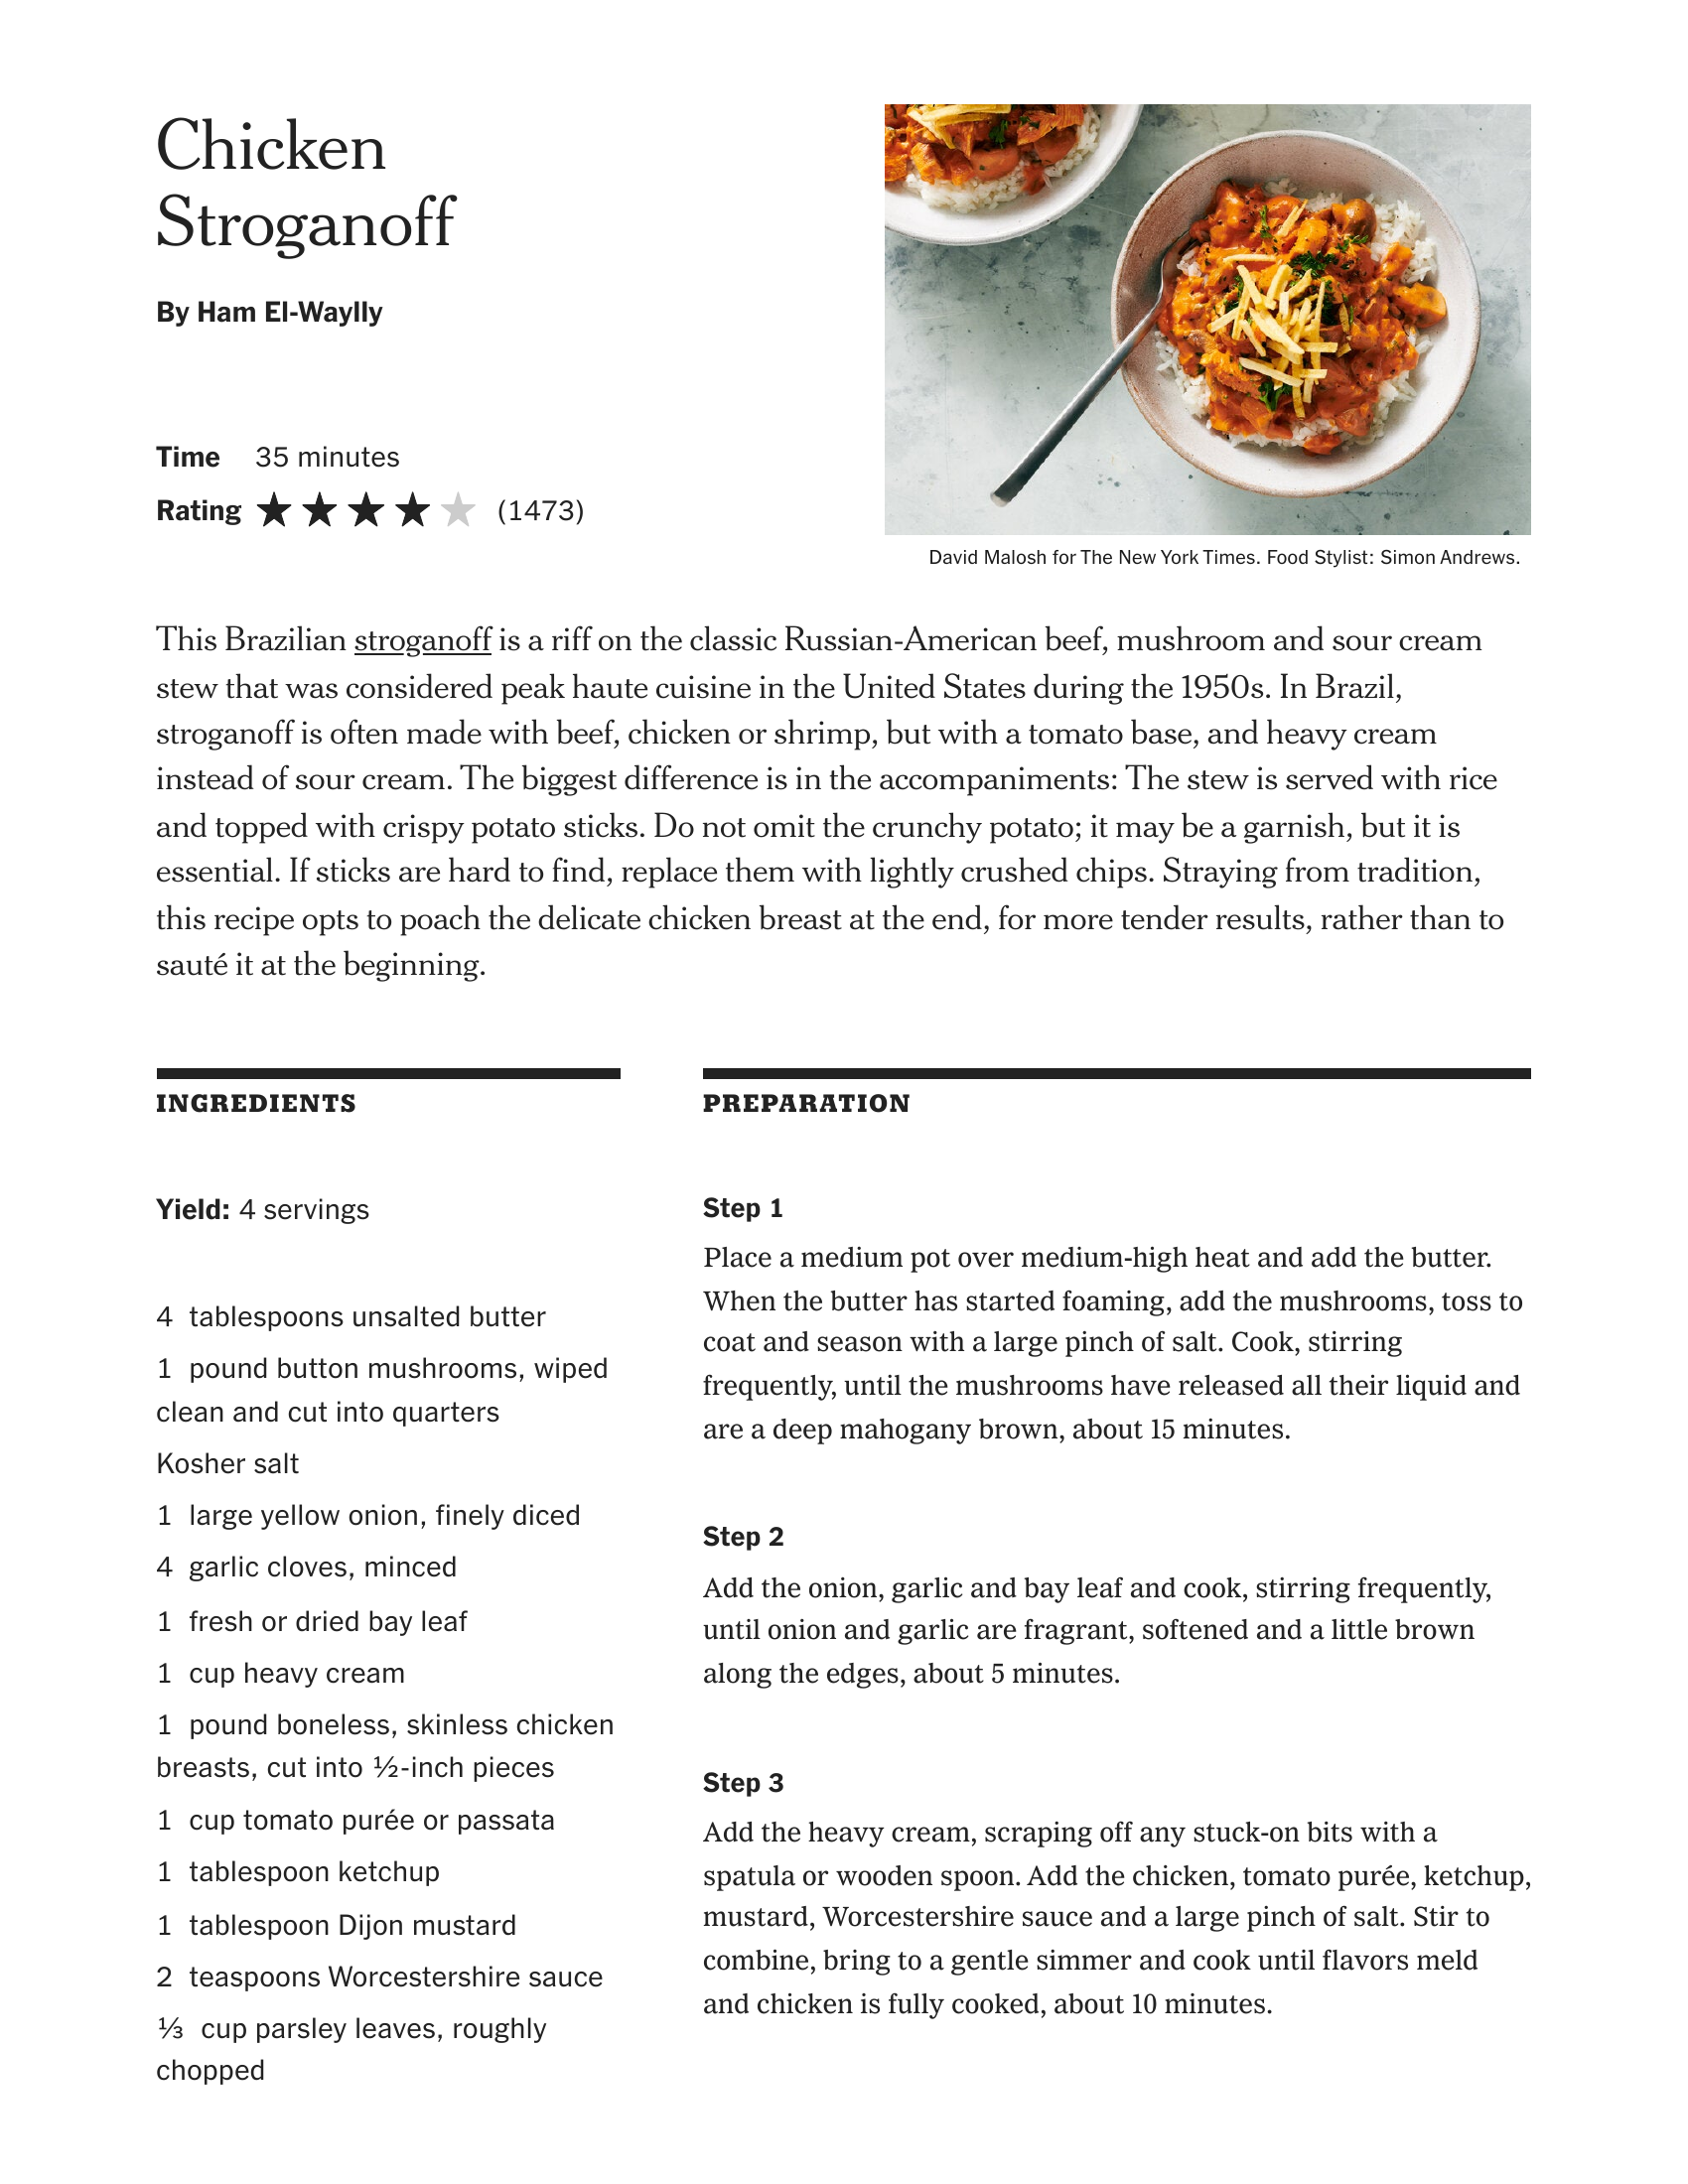

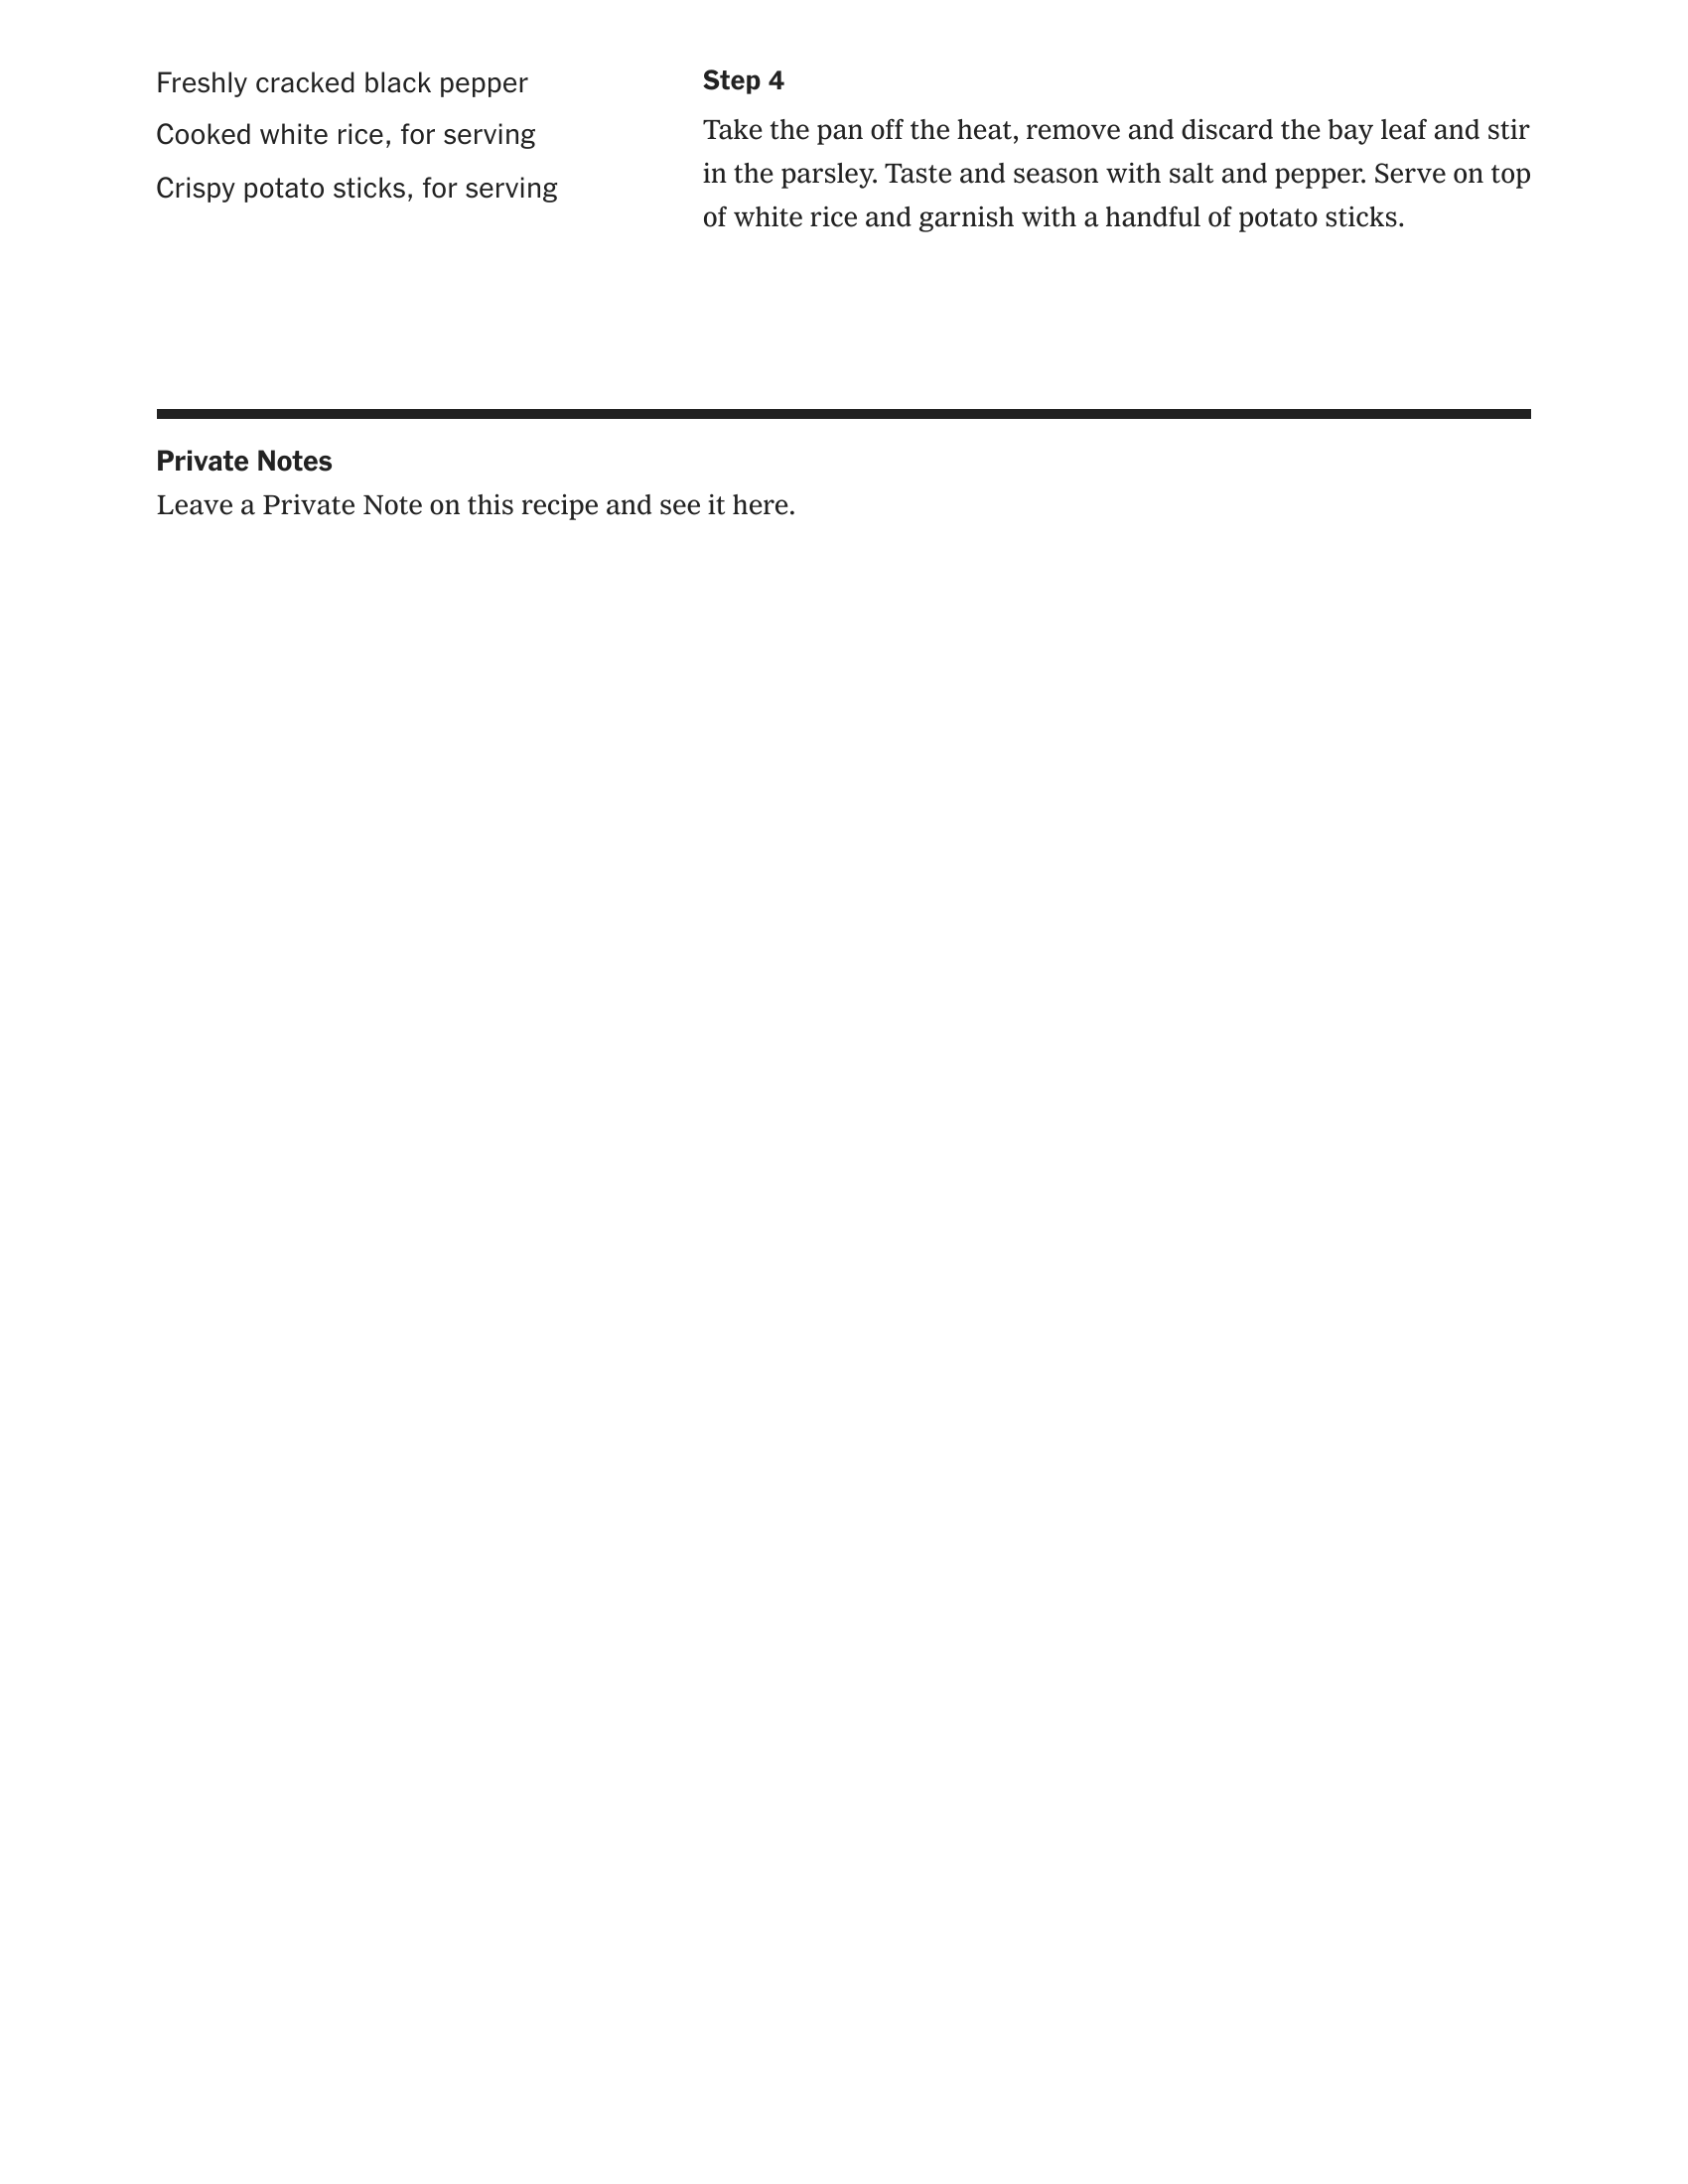

In [155]:
chat_history = context_enabled("I want a chicken recipe", "")

I am searching using this search term: 
No onion recipes
[Document(page_content='Private Notes\nLeave a Private Note on this recipe and see it here.', metadata={'source': 'data/Everyday Pancakes Recipe - NYT Cooking.pdf', 'page': 1})]
{'source': 'data/Everyday Pancakes Recipe - NYT Cooking.pdf', 'page': 1}
Private Notes
Leave a Private Note on this recipe and see it here.
Unfortunately, this recipe does require onion. However, you can always leave out the onion if you prefer.


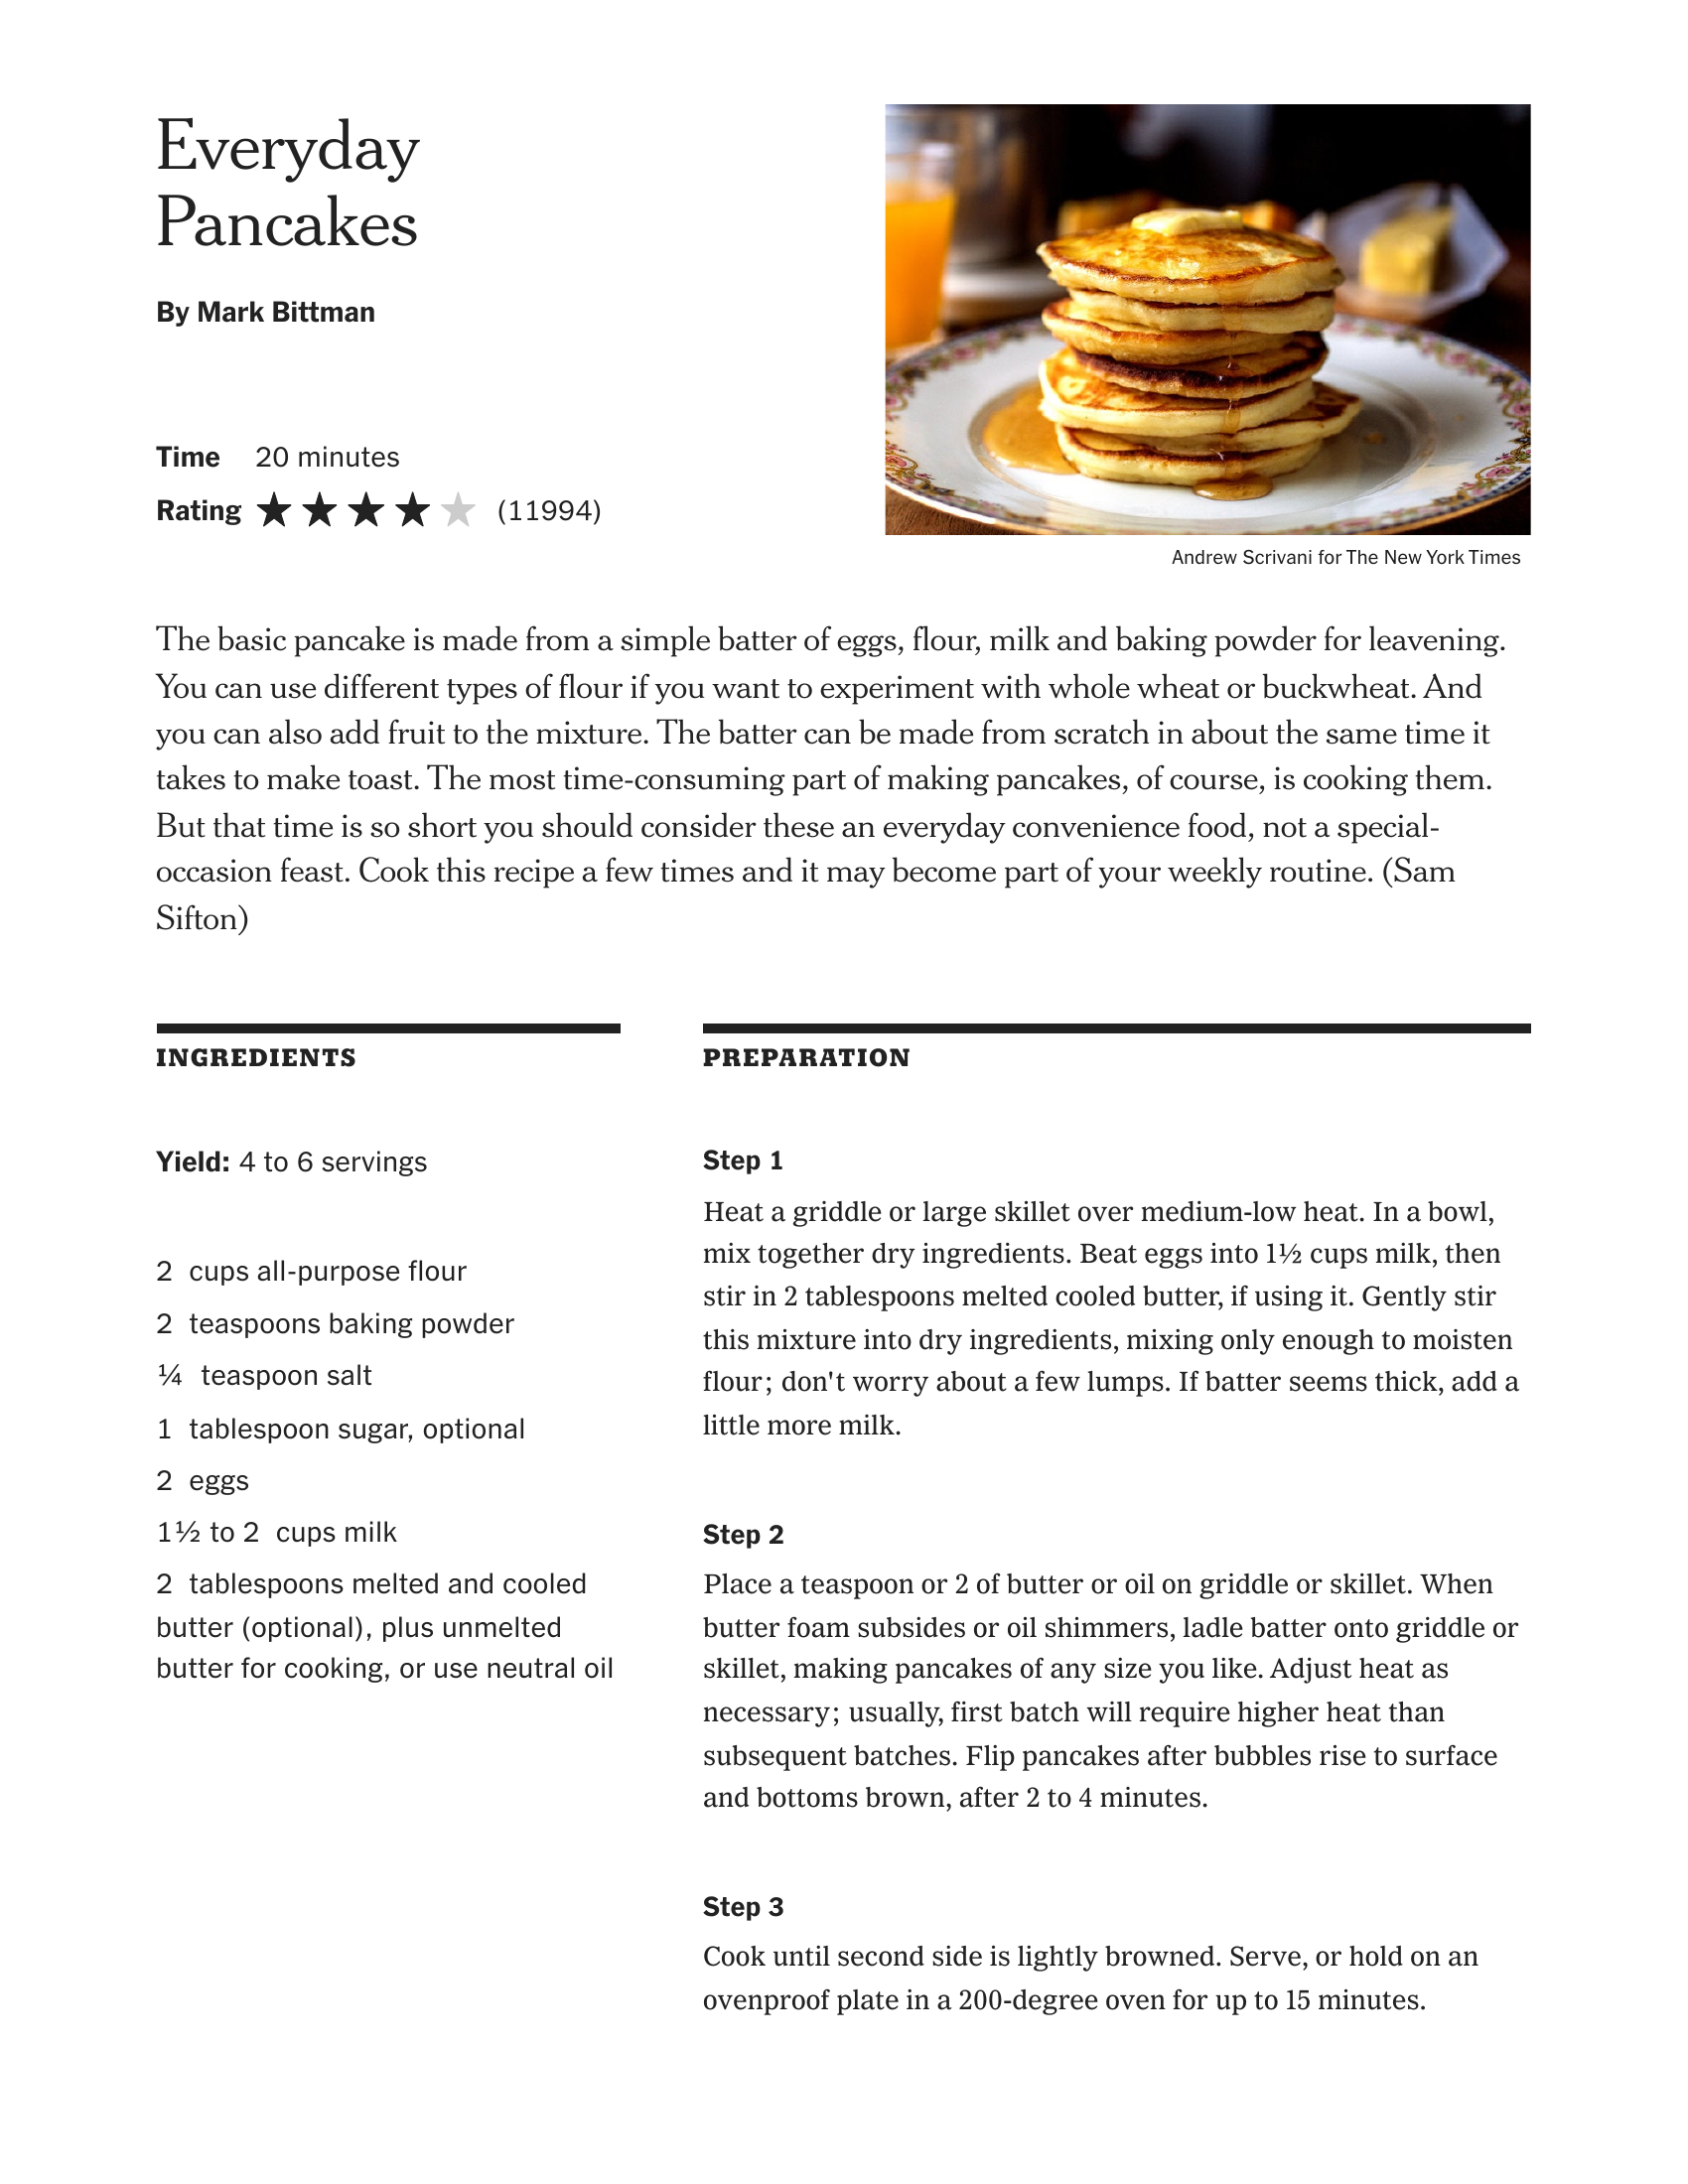

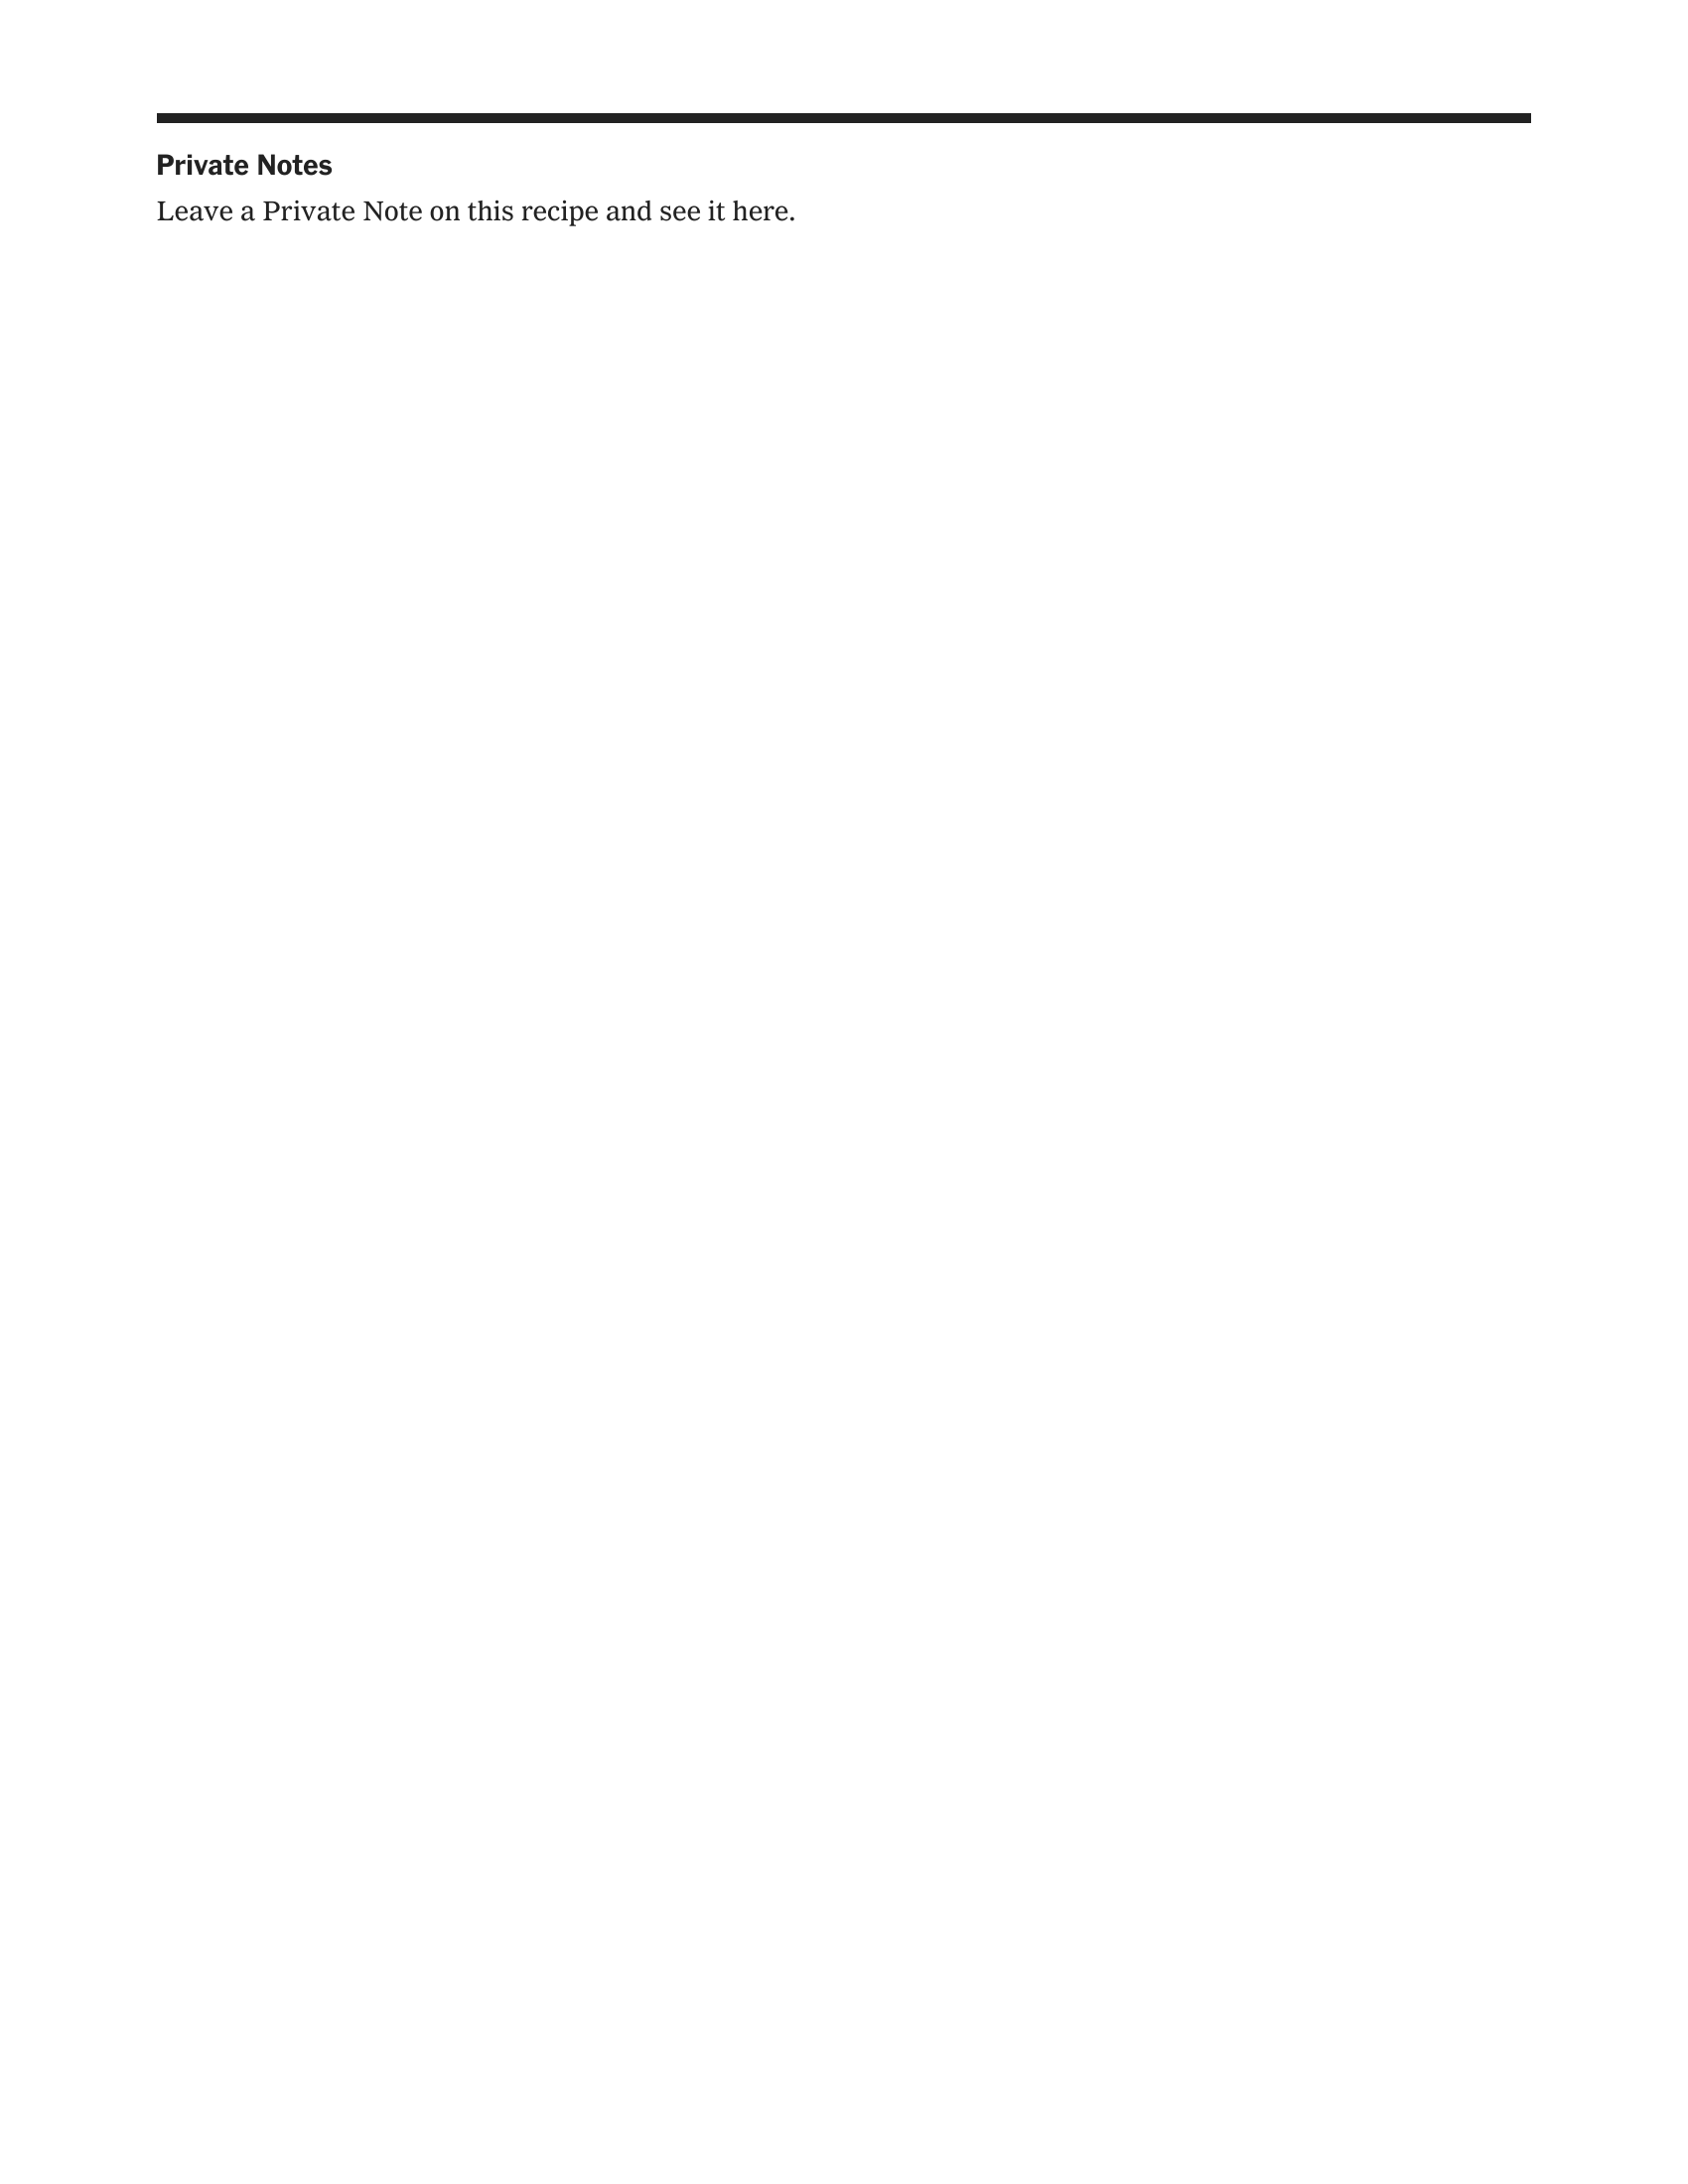

In [156]:
chat_history = context_enabled("Do you have one without onion?", chat_history)